# NGC2264 masked Power Spectra

In [1]:
import aplpy
from astropy.io import fits
import pyregion
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'family': 'serif', 'size': 26})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

In [24]:
figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/new/hires.02.surfden.r18p2as.cut_proj.fits'

In [94]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header
im -= np.mean(im)

#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

Load MnGSeg functions

In [44]:
from pywavan import powspec, fan_trans

Calculate the wavelet segmentation for the entire map

In [75]:
#Set a list of q
q=[]
q=[2.5]*26
newdim = np.array((850,850))

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, apodize=0.98, smooth=False, angular=False)
M = wav_k.size

850 850


## Center region

In [95]:
center = pyregion.open('/Users/robitaij/postdoc/Herschel/NGC2264/new/center.reg')

mask_center = center.get_mask(HDU[0])
imcenter = mask_center*im
HDUcenter = fits.PrimaryHDU(imcenter,header=header)

INFO: Auto-setting vmin to -2.146e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.518e+22 [aplpy.core]


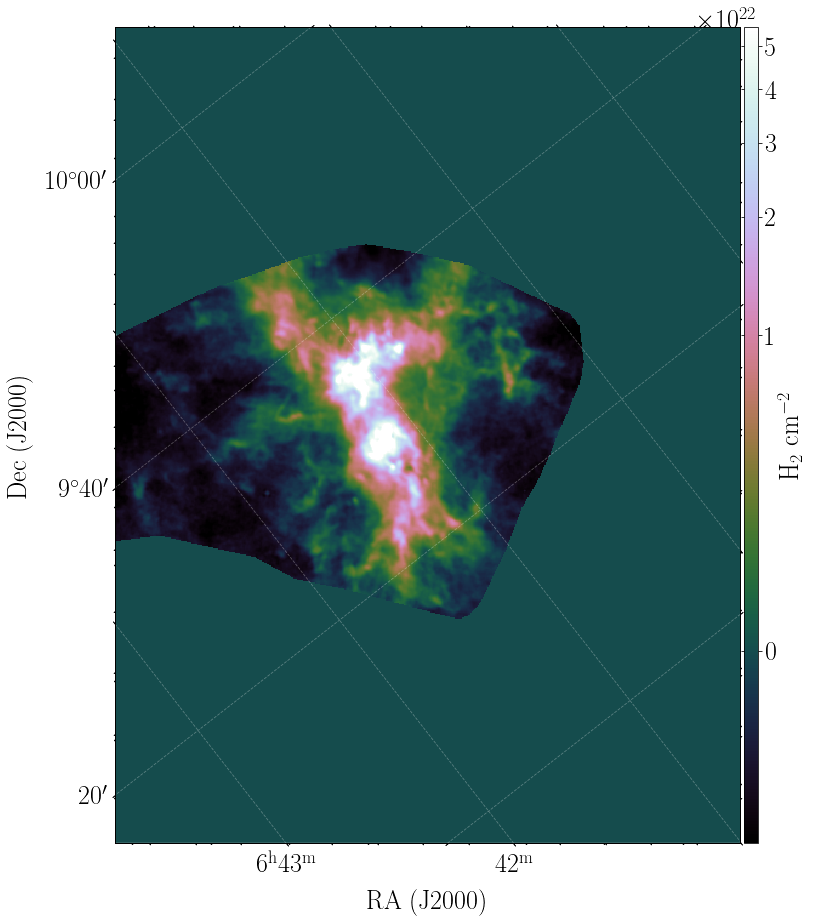

In [96]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(HDUcenter,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')


Fourier Power Spectrum

In [145]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]

#Apodization
tapper = apodize(nb,na,0.98)
imcentert = imcenter *tapper
newdim = np.array((850,850))
imcenterr = padding(imcentert,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imcenterr, reso=reso)

noise = spec_k[325]

Beam estimation

In [92]:
beam250 = fits.open('/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_250.fits')[0].data

beam250r = padding(beam250,newdim[0],newdim[1])
Bwt, BS11a, wav_k, BS1a, Bq = fan_trans(beam250r, reso=reso, q=0, smooth=False, angular=False)
del Bwt, BS11a, Bq

BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0  #Spectrum normalisation

tab_k, spec_kbeam = powspec(beam250r, reso=reso)
spec_kbeamn = spec_kbeam/spec_kbeam[0]

Apply mask on the wavelet coefficients

In [109]:
S1aC = np.zeros((3,M))
S11buff = np.zeros(newdim)

for ii in range(M):
    S11buff = S11a[ii,:,:]
    S1aC[0,ii] = np.sum(S11buff[mask_center == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[M+ii,:,:]
    S1aC[1,ii] = np.sum(S11buff[mask_center == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[2*M+ii,:,:]
    S1aC[2,ii] = np.sum(S11buff[mask_center == 1]) / (newdim[0] * newdim[1])

In [144]:
#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[6:20]), np.log((S1aC[1,6:20]-noise)/(BS1an[6:20])),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power fit Coherent')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

AG, covG = np.polyfit(np.log(wav_k[10:16]), np.log((S1aC[2,10:16]-noise)/(BS1an[10:16])),deg=1,cov=True)
fitG = np.exp(AG[1])*wav_k**AG[0]
print('Power fit Gaussian')
print('A, Gamma = ', np.exp(AG[1]), AG[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(covG)[1])), np.sqrt(np.diag(covG)[0]))

Power fit Coherent
A, Gamma =  4.949095875494944e+43 -2.088975355362262
Uncertainties =  1.1147591888281212 0.07490518878799649
Power fit Gaussian
A, Gamma =  1.1834539139138926e+40 -3.7976120810313603
Uncertainties =  1.241164522742236 0.21331868425820255


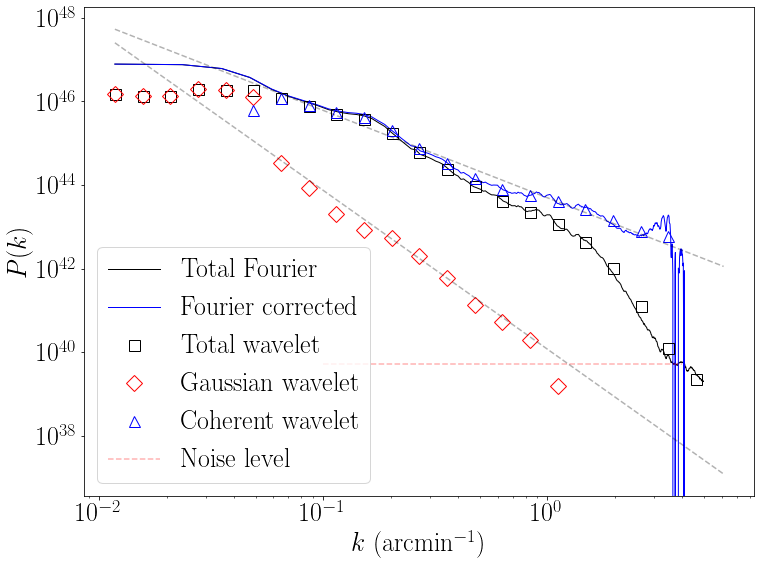

In [146]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier', lw=1.0)
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], S1aC[0,:-1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k[:-1], (S1aC[2,:-1]-noise)/BS1an[:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], (S1aC[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([1e-1,4],[noise,noise],'--',color='red',linewidth=1.5,alpha=0.3,label='Noise level')
plt.plot(wav_k, fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot(wav_k, fitG,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

In [133]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=(0)) + np.sum(wt[2*M:2*M+6,:,:],axis=(0))
Gaussian = np.sum(wt[2*M+6:3*M,:,:],axis=(0))

INFO: Auto-setting vmin to -9.166e+20 [aplpy.core]
INFO: Auto-setting vmax to  9.232e+20 [aplpy.core]
INFO: Auto-setting vmin to -2.423e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.679e+22 [aplpy.core]


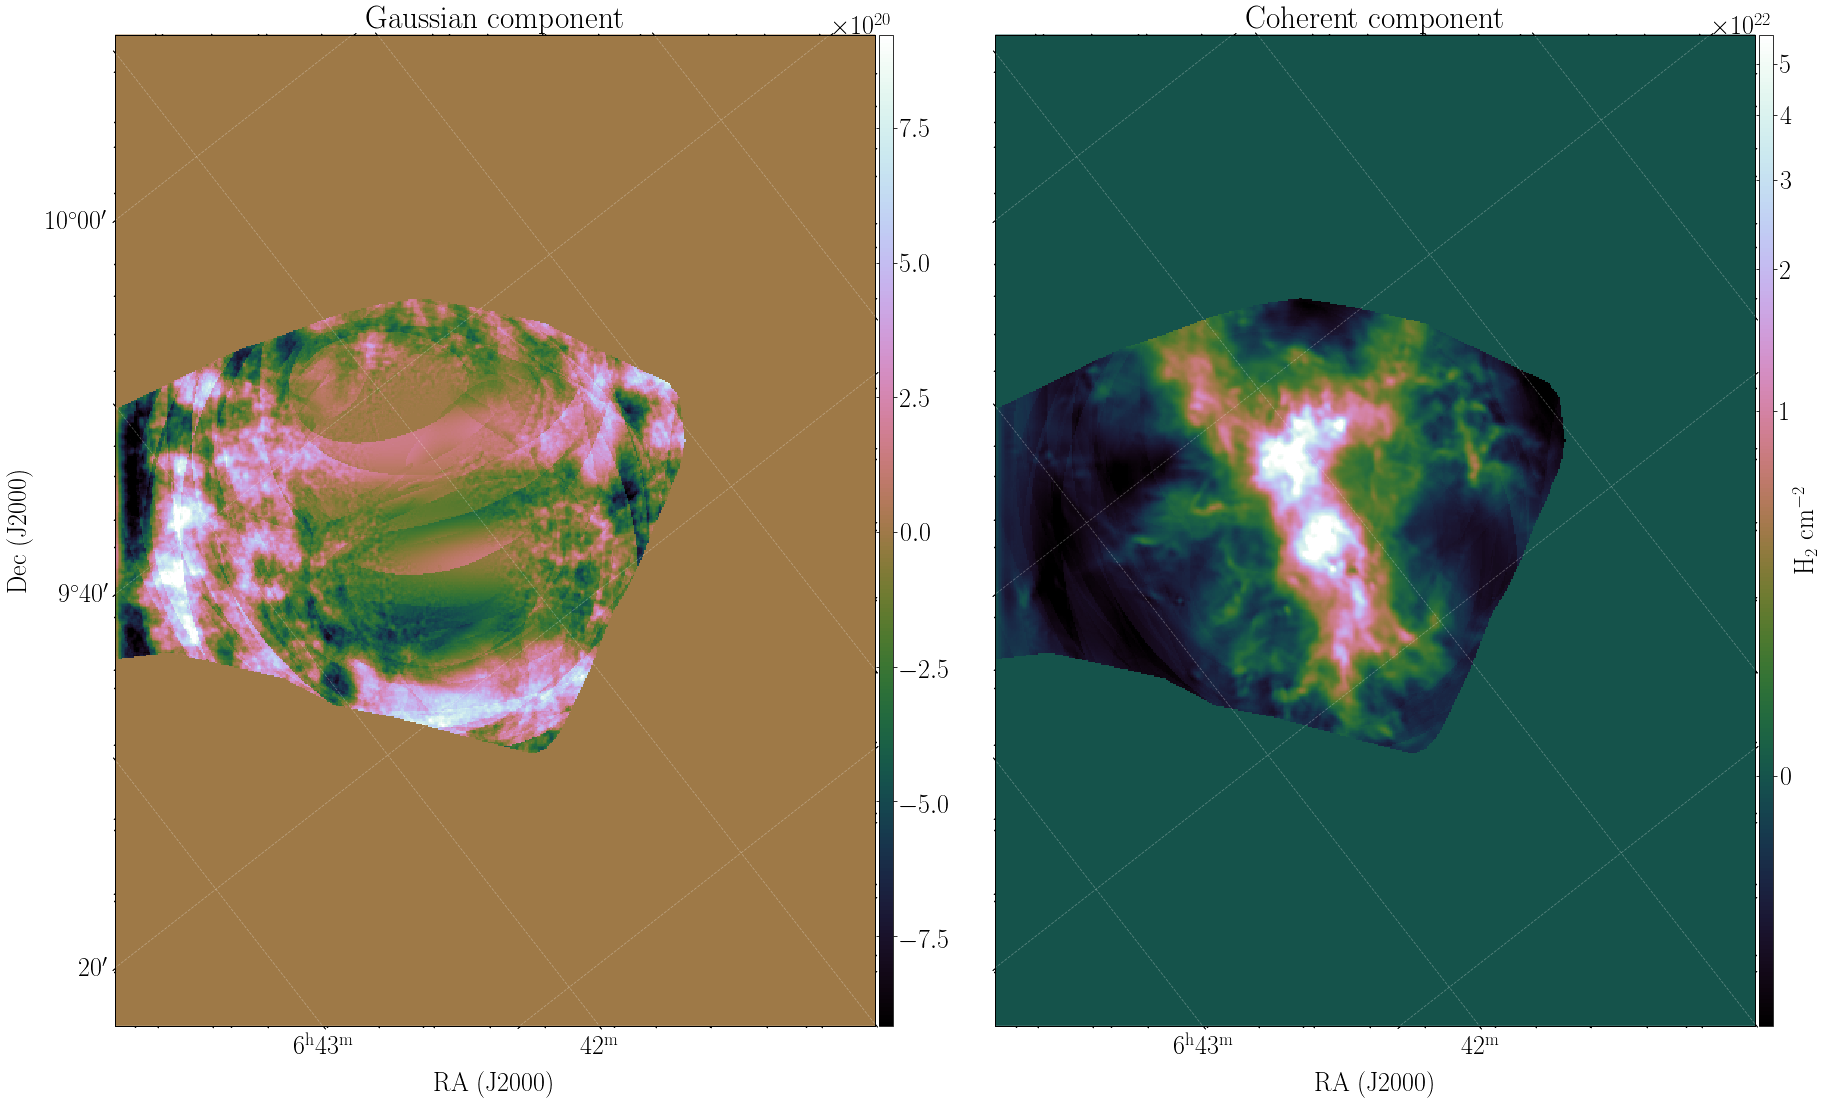

In [134]:
fig_all = plt.figure(1, figsize=(26,30))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian.real*mask_center,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.set_title('Gaussian component')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent.real*mask_center,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.axis_labels.hide_y()
fig.tick_labels.hide_y()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()

## South region

In [126]:
south = pyregion.open('/Users/robitaij/postdoc/Herschel/NGC2264/new/south.reg')

mask_south = south.get_mask(HDU[0])
imsouth = mask_south*im
HDUsouth = fits.PrimaryHDU(imsouth,header=header)

INFO: Auto-setting vmin to -2.526e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.947e+21 [aplpy.core]


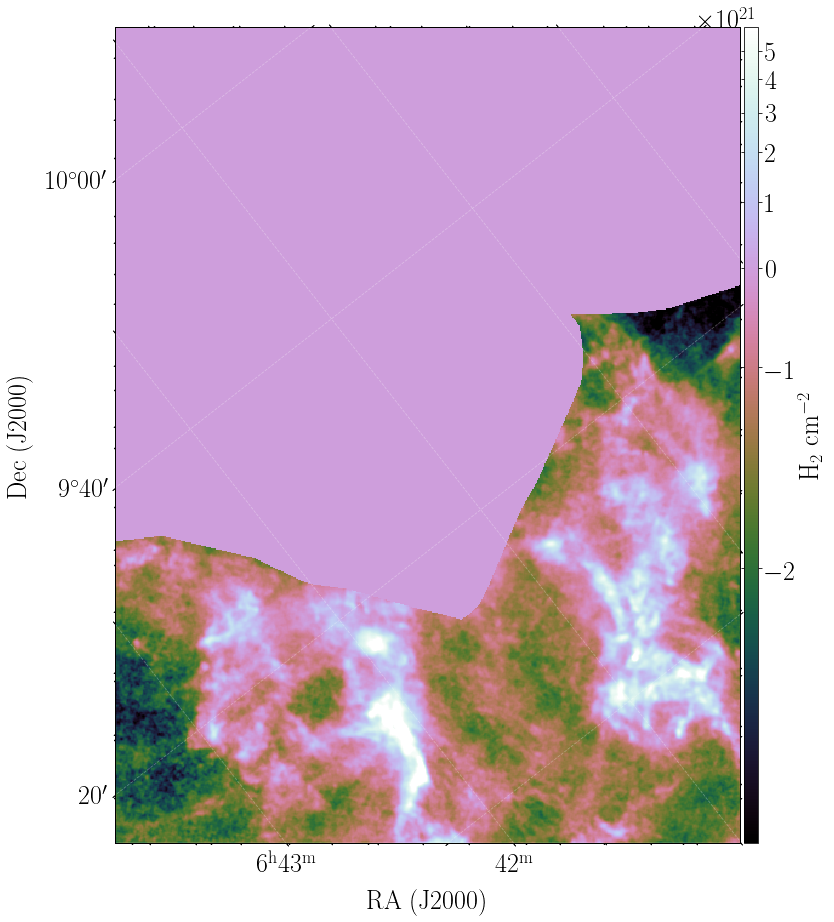

In [127]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(HDUsouth,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')


Fourier Power Spectrum

In [153]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]

#Apodization
tapper = apodize(nb,na,0.98)
imsoutht = imsouth *tapper
newdim = np.array((850,850))
imsouthr = padding(imsoutht,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imsouthr, reso=reso)

noise = spec_k[325]

Beam estimation

Apply mask on the wavelet coefficients

In [131]:
S1aS = np.zeros((3,M))
S11buff = np.zeros(newdim)

for ii in range(M):
    S11buff = S11a[ii,:,:]
    S1aS[0,ii] = np.sum(S11buff[mask_south == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[M+ii,:,:]
    S1aS[1,ii] = np.sum(S11buff[mask_south == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[2*M+ii,:,:]
    S1aS[2,ii] = np.sum(S11buff[mask_south == 1]) / (newdim[0] * newdim[1])

In [163]:
#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[8:19]), np.log((S1aS[1,8:19]-noise)/(BS1an[8:19])),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power fit Coherent')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

#Fit IDL
A = [0.0193006*1e21**2., -4.00988, 0.0132751*1e21**2.]
fitG = A[0]*wav_k**(A[1])+A[2]

Power fit Coherent
A, Gamma =  7.939077481447042e+41 -2.2581951314447495
Uncertainties =  1.037246081553879 0.03129090077598822


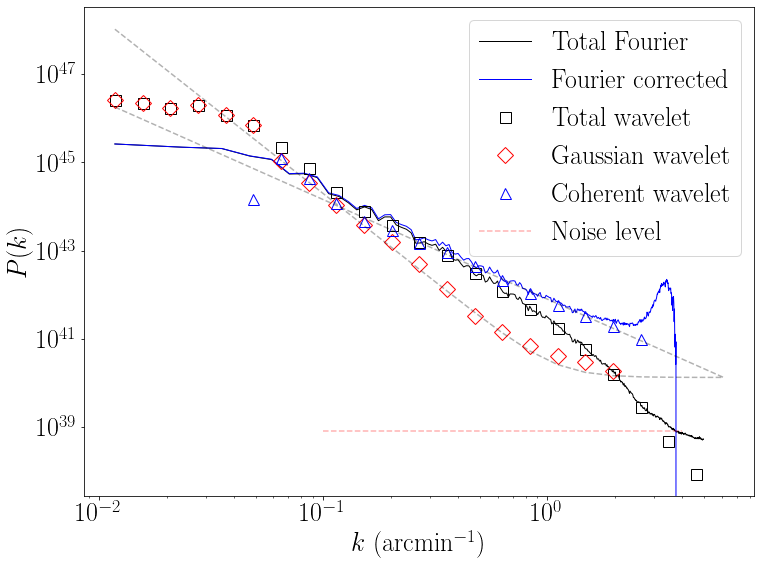

In [164]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier', lw=1.0)
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], S1aS[0,:-1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k[:-1], (S1aS[2,:-1]-noise)/BS1an[:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], (S1aS[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([1e-1,4],[noise,noise],'--',color='red',linewidth=1.5,alpha=0.3,label='Noise level')
plt.plot(wav_k, fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot(wav_k, fitG,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

INFO: Auto-setting vmin to -2.016e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.375e+21 [aplpy.core]
INFO: Auto-setting vmin to -2.273e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.303e+21 [aplpy.core]


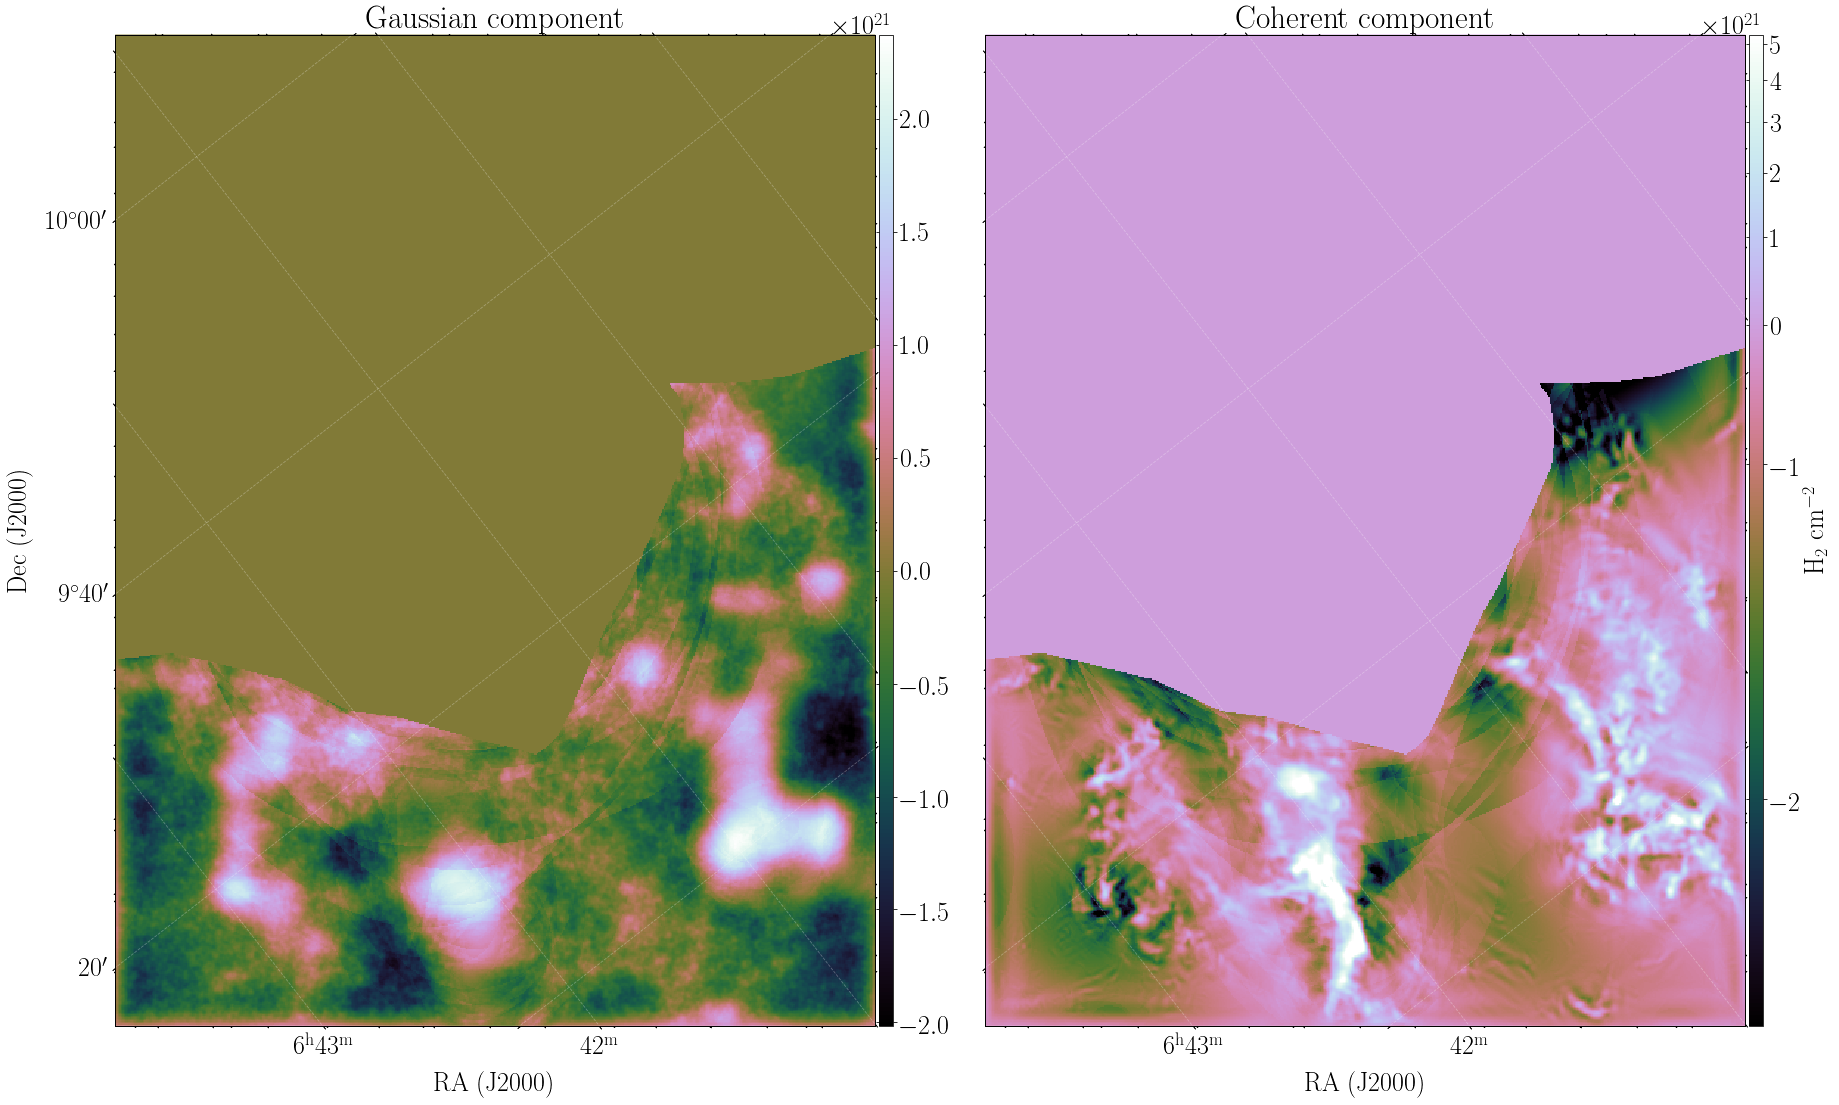

In [135]:
fig_all = plt.figure(1, figsize=(26,30))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian.real*mask_south,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.set_title('Gaussian component')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent.real*mask_south,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.axis_labels.hide_y()
fig.tick_labels.hide_y()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()

## North region

In [136]:
north = pyregion.open('/Users/robitaij/postdoc/Herschel/NGC2264/new/north.reg')

mask_north = north.get_mask(HDU[0])
imnorth = mask_north*im
HDUnorth = fits.PrimaryHDU(imnorth,header=header)

INFO: Auto-setting vmin to -2.893e+21 [aplpy.core]
INFO: Auto-setting vmax to  6.933e+21 [aplpy.core]


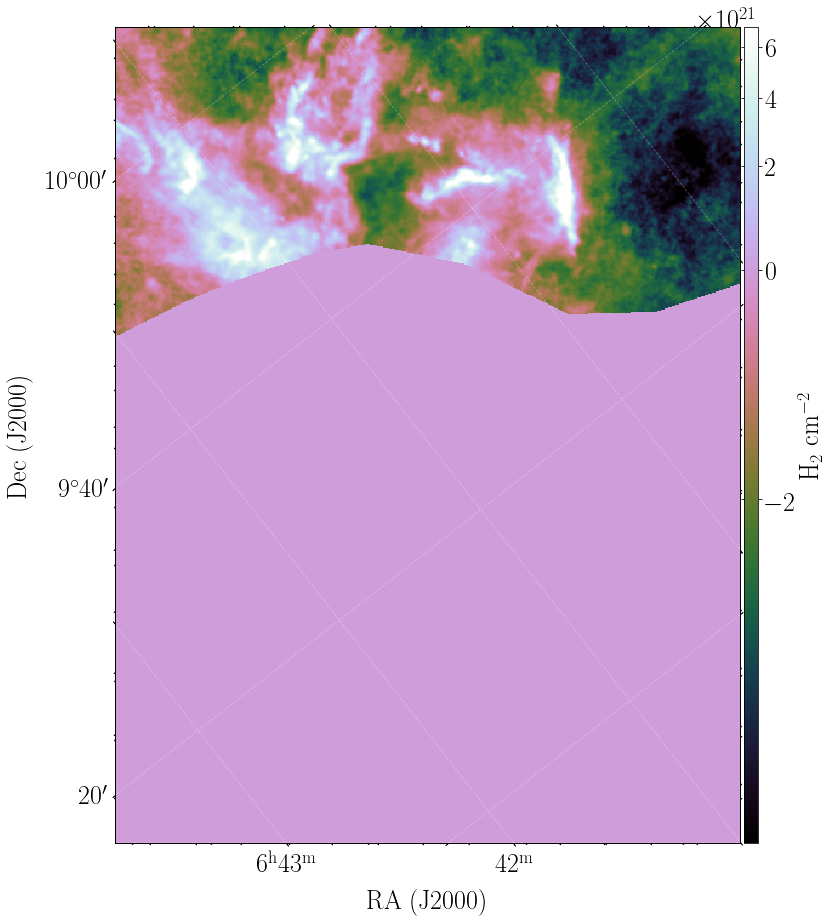

In [138]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(HDUnorth,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')


Fourier Power Spectrum

In [169]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]

#Apodization
tapper = apodize(nb,na,0.98)
imnortht = imnorth *tapper
newdim = np.array((850,850))
imnorthr = padding(imnortht,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imnorthr, reso=reso)

noise = spec_k[325]

Beam estimation

Apply mask on the wavelet coefficients

In [140]:
S1aN = np.zeros((3,M))
S11buff = np.zeros(newdim)

for ii in range(M):
    S11buff = S11a[ii,:,:]
    S1aN[0,ii] = np.sum(S11buff[mask_north == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[M+ii,:,:]
    S1aN[1,ii] = np.sum(S11buff[mask_north == 1]) / (newdim[0] * newdim[1])
    S11buff = S11a[2*M+ii,:,:]
    S1aN[2,ii] = np.sum(S11buff[mask_north == 1]) / (newdim[0] * newdim[1])

In [173]:
#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[9:17]), np.log((S1aN[1,9:17]-noise)/(BS1an[9:17])),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power fit Coherent')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

#Fit IDL
A = [0.00994359*1e21**2., -4.17546, 0.0135866*1e21**2.]
fitG = A[0]*wav_k**(A[1])+A[2]

Power fit Coherent
A, Gamma =  1.5830098105206654e+42 -2.0697496465887313
Uncertainties =  1.0213313815351512 0.01915363231320185


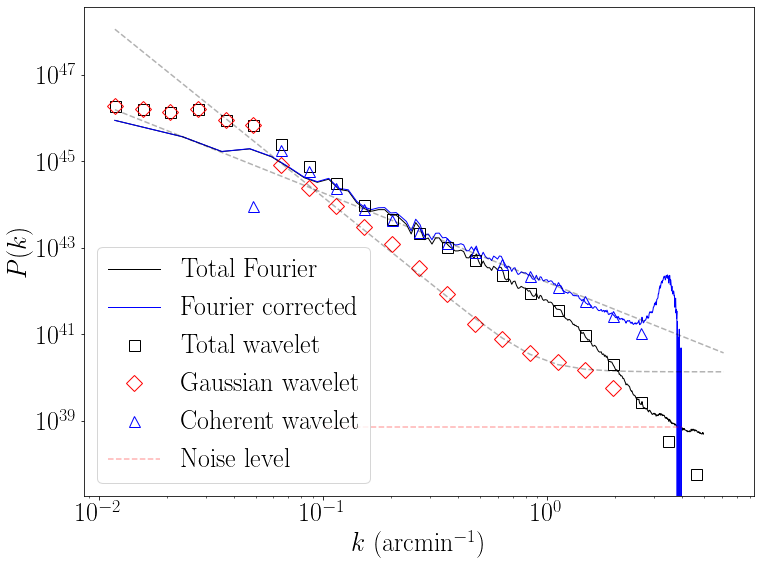

In [174]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier', lw=1.0)
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], S1aN[0,:-1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k[:-1], (S1aN[2,:-1]-noise)/BS1an[:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], (S1aN[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([1e-1,4],[noise,noise],'--',color='red',linewidth=1.5,alpha=0.3,label='Noise level')
plt.plot(wav_k, fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot(wav_k, fitG,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

INFO: Auto-setting vmin to -1.578e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.711e+21 [aplpy.core]
INFO: Auto-setting vmin to -2.965e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.125e+21 [aplpy.core]


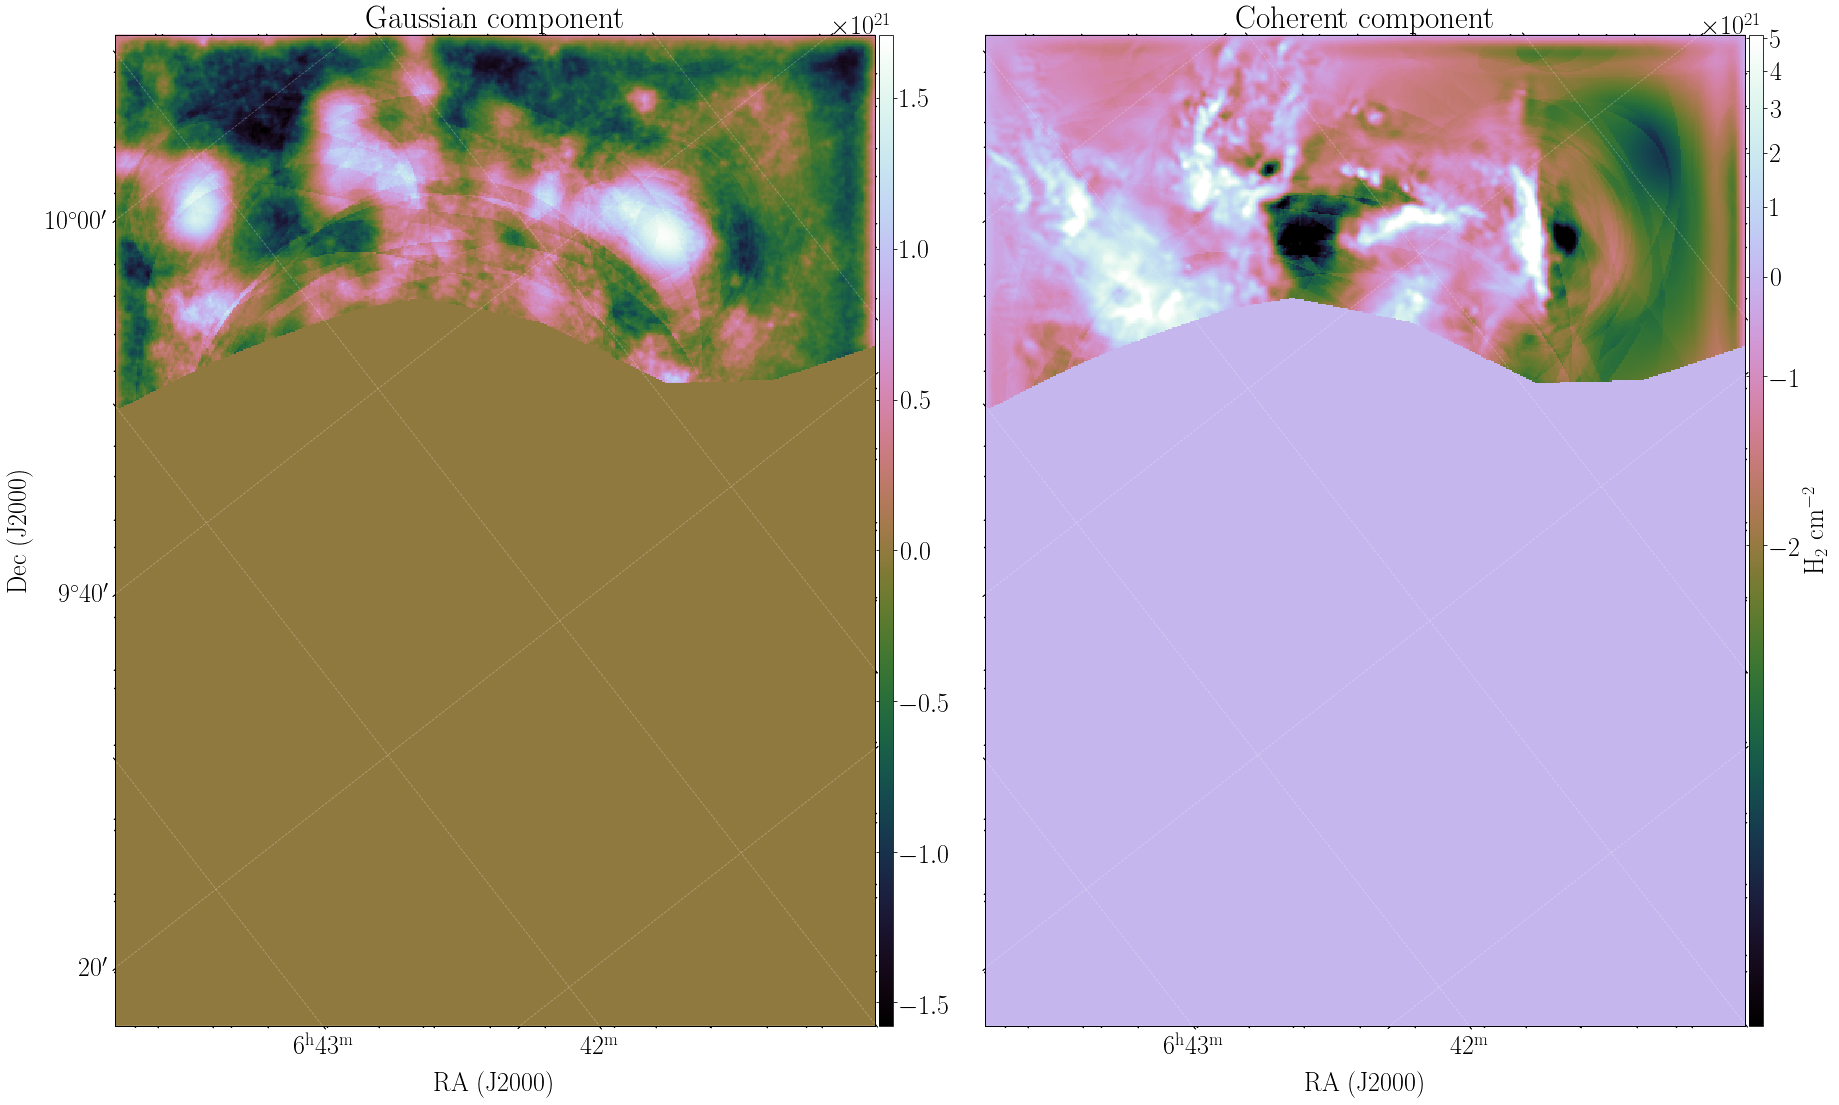

In [142]:
fig_all = plt.figure(1, figsize=(26,30))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian.real*mask_north,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.set_title('Gaussian component')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent.real*mask_north,header=header), figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.axis_labels.hide_y()
fig.tick_labels.hide_y()
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()